In [1]:
# Bibliotecas
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Limpeza de dados:
#### Tratamento de dados faltantes e discrepantes:
A primeira etapa é a limpeza de dados, o tratamento de dados faltantes e irregulares.

No notebook anterior, já havia sido realizada uma breve análise que identificava dados faltantes. Ao todo, 20 instâncias foram identificadas com dados errôneos nas colunas x, y e z.

In [3]:
# Ler o dataframe, exibir primeiras dez linhas, remover coluna de índice
df = pd.read_csv('../data/raw/diamonds.csv', index_col=[0])

df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Os valores mínimos das colunas x, y e z são 0, o que indica a presença de instâncias com valores de dimensão faltantes. Identificar o numero de diamantes não-tridimensionais se faz necessário para entender, exatamente, quantas instâncias estão comprometidas.

In [7]:
count_0 = ((df['x'] == 0) |
           (df['y'] == 0) |
           (df['z'] == 0)).sum()

print(f'Total de instâncias com dimensão "0": {count_0}')

Total de instâncias com dimensão "0": 20


Com apenas 20 instâncias em um dataset de 53940, é segura a decisão de removê-las.

In [8]:
# Remoção de diamantes com dimensões faltantes
df = df.drop(df[df['x'] == 0].index)
df = df.drop(df[df['y'] == 0].index)
df = df.drop(df[df['z'] == 0].index)

# Verifica o novo tamanho do set
df.shape

(53920, 10)

Por fim, verificamos se algum dado no dataset é NaN:

In [12]:
nan_finder = df.isna().sum()

print(nan_finder)

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


Com a certeza de que não possuímos valores ausentes e sabendo também que valores discrepantes iniciais foram removidos, podemos partir para a próxima etapa: a busca por outliers usando um pairplot:

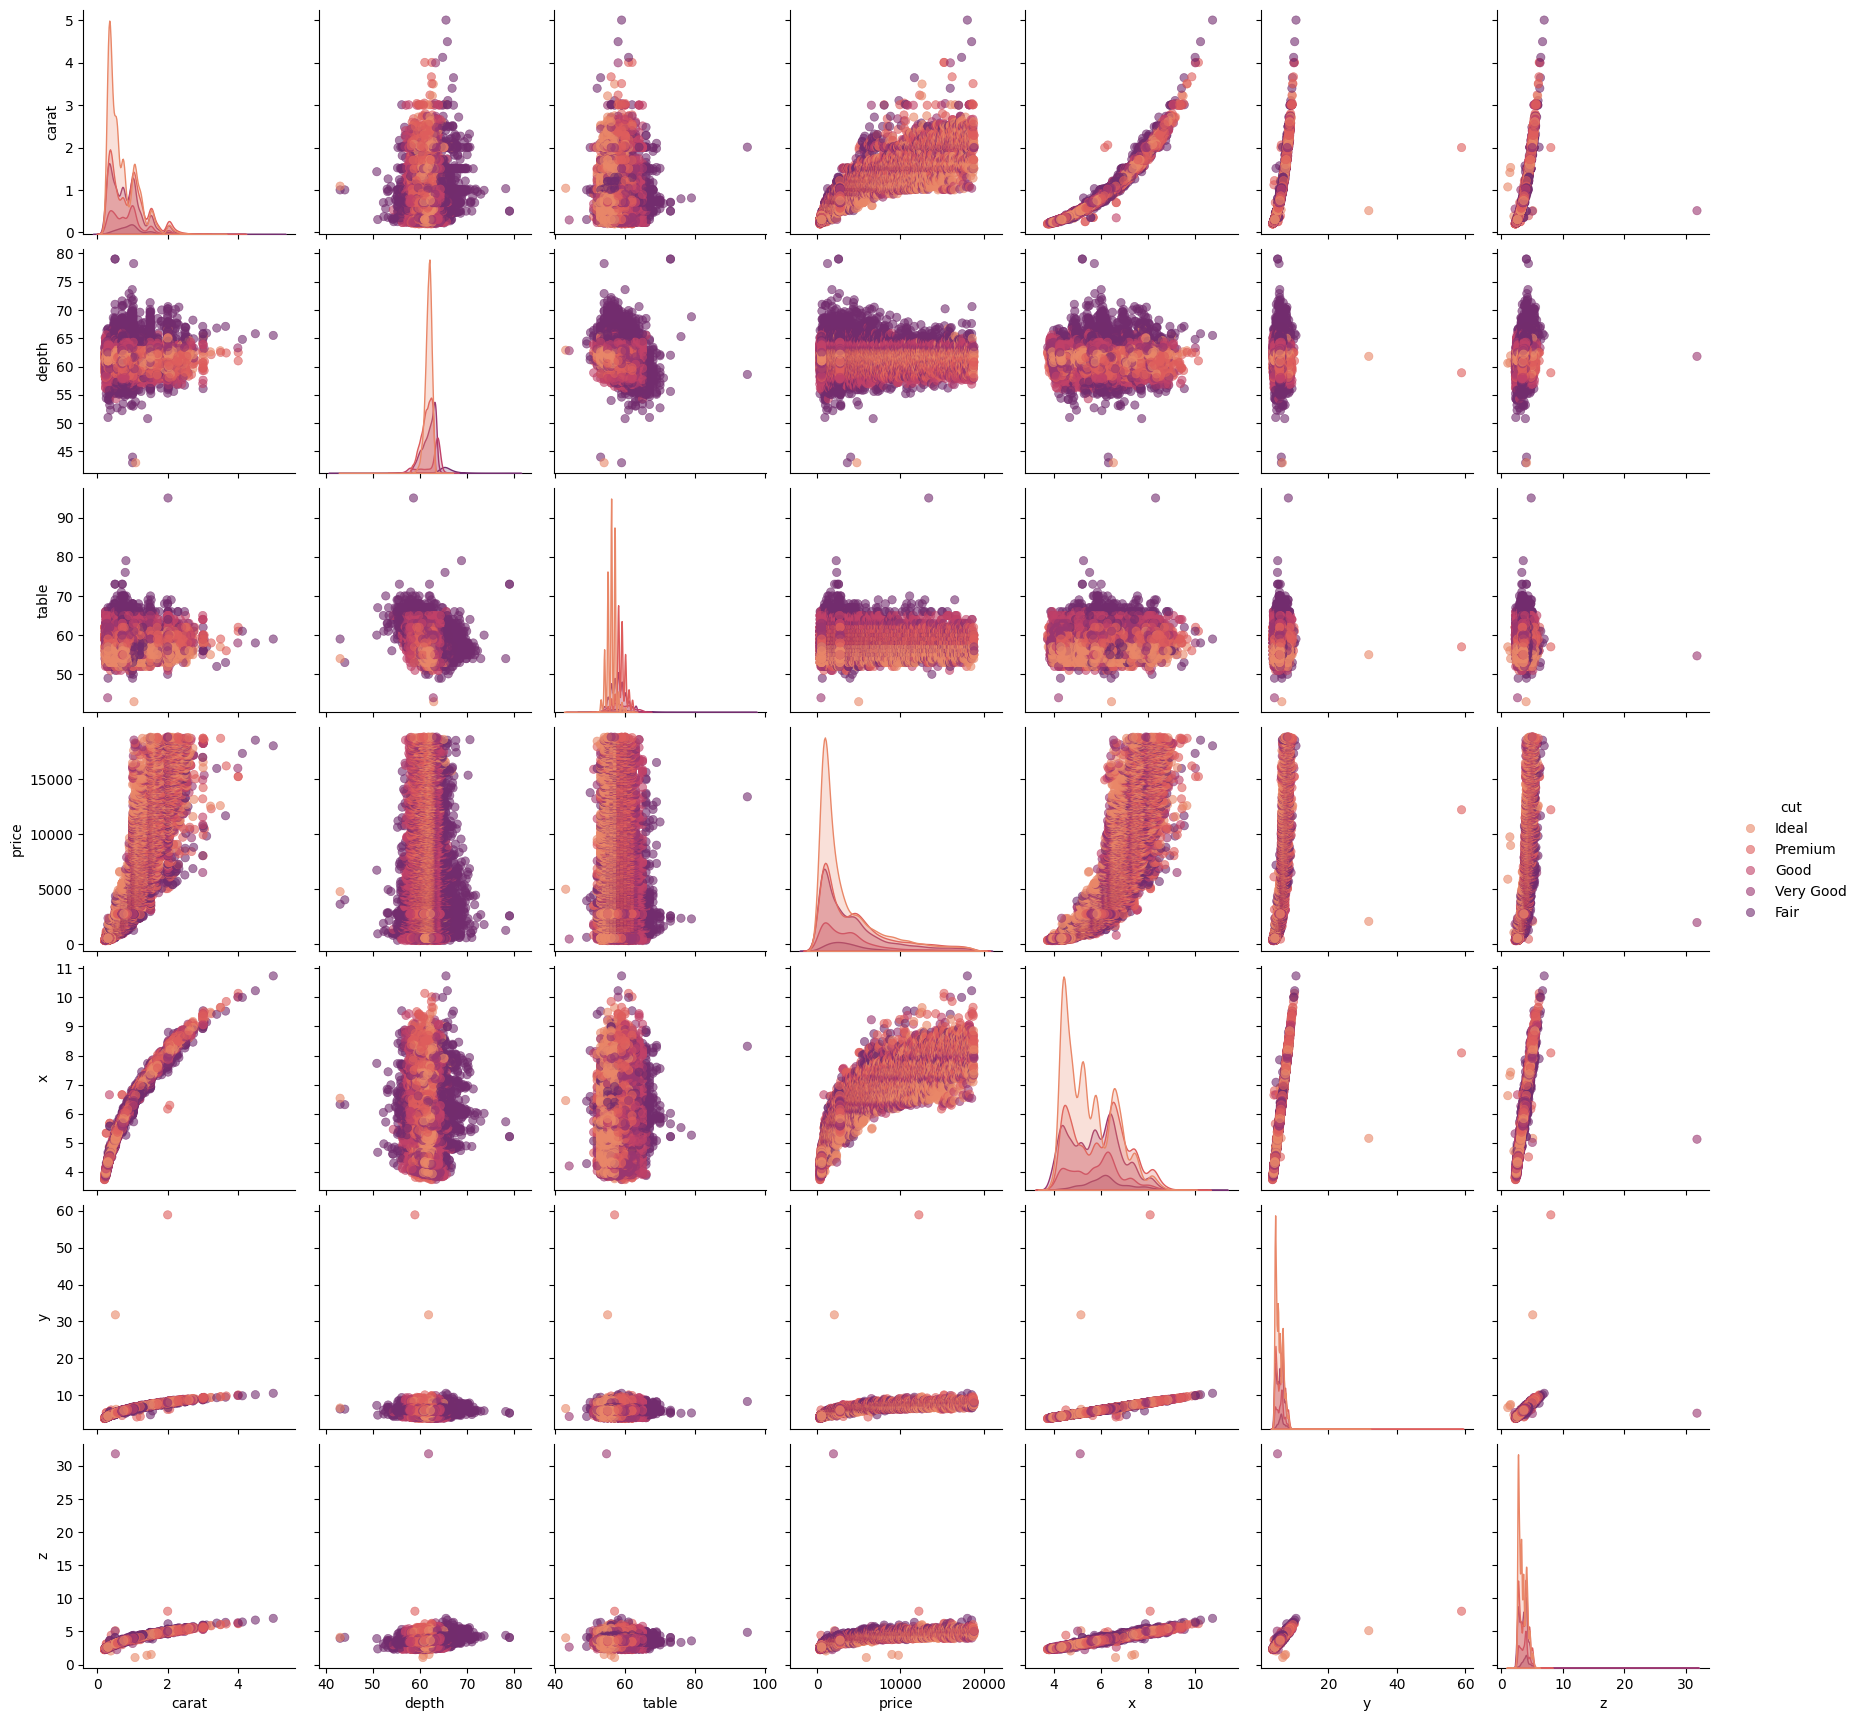

In [17]:
sns.pairplot(df, diag_kind = 'kde',
             hue = 'cut', palette = 'flare',
             plot_kws = dict(edgecolor = None, alpha = 0.6))

plt.show()

É possível perceber a presença de alguns outliers enviesando o pairplot acima. Os pontos isolados nos plots são problemáticos durante o treinamento de um modelo de predição e devem ser eliminados. Os plots de dimensão Y e Z possuem valores discrepantes. Os plots de Mesa e Profundidade possuem valores que precisam ser eliminados para melhorar o treinamento do modelo.

Para definir o limiar de eliminação, usaremos uma linha de regressão:

In [136]:
# Cores para usar nos regplots
# scatter color
sc = '#ECAE7F'
# line color
lc = '#822F70'
# cmap de bivalência
b_pal = sns.diverging_palette(9, 313, s=49, as_cmap=True)

# Estilo das grids
sns.set_style('whitegrid')

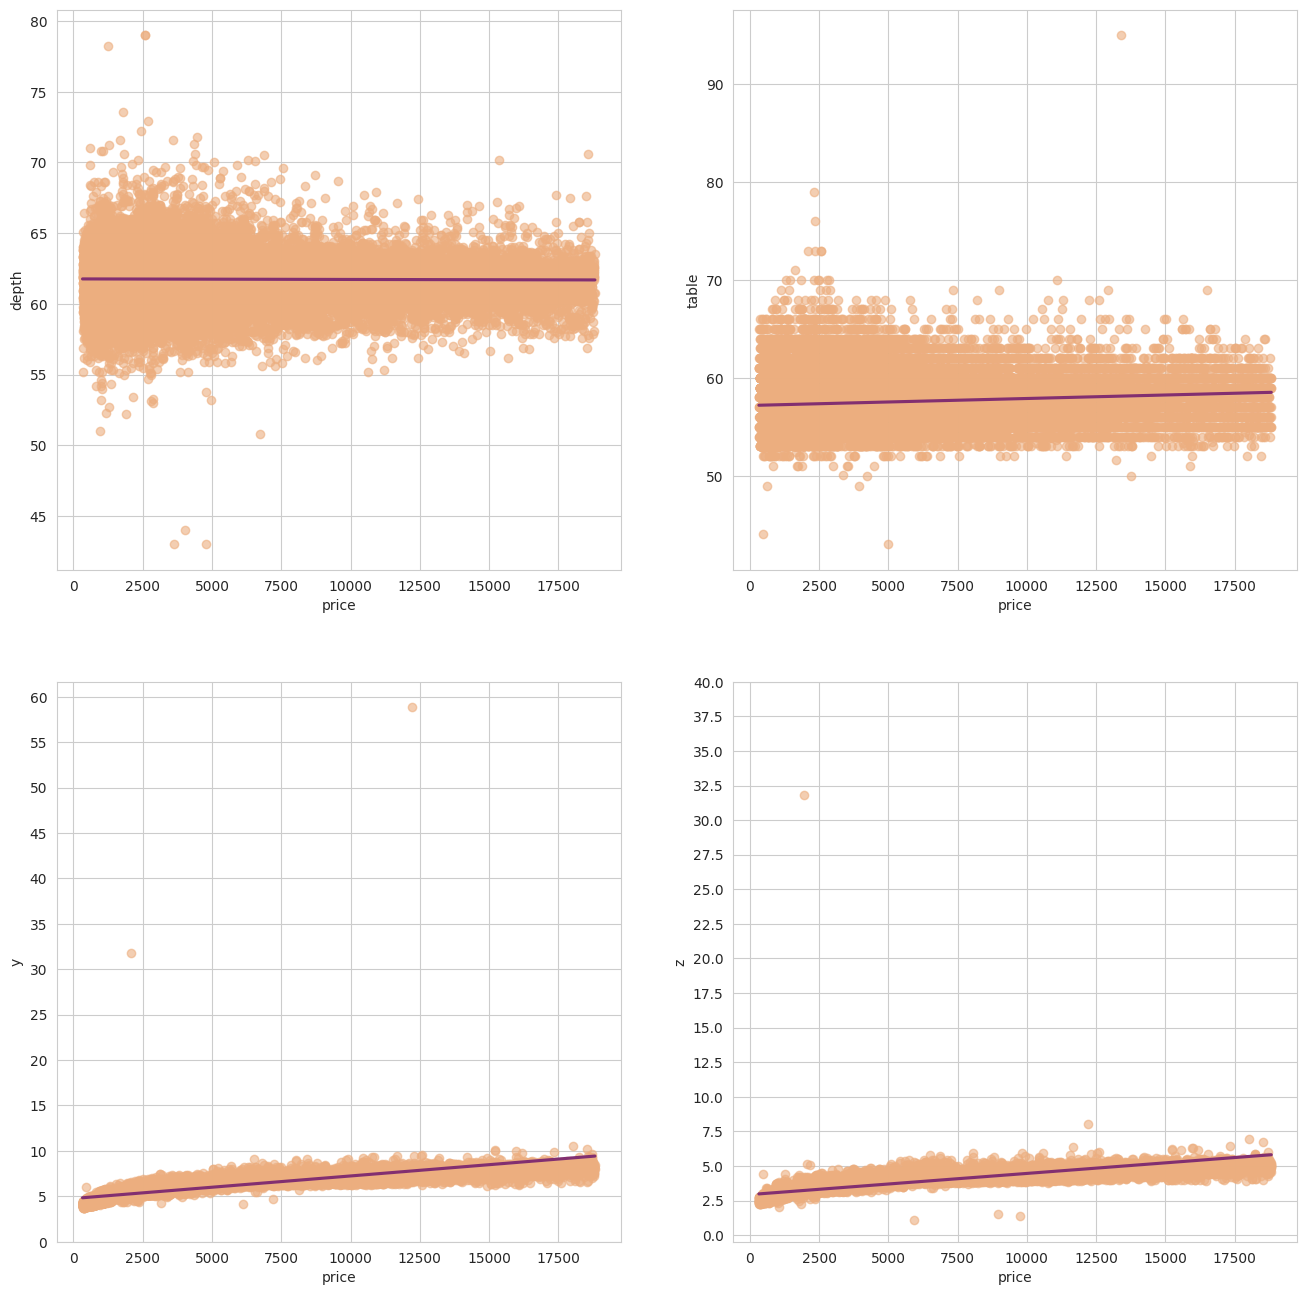

In [65]:
# Cria uma grid com linhas de regressão para verificar os plots
# com um grande volume de outliers no pairplot:

fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Profundidade
sns.regplot(data = df, x = 'price', y = 'depth',
            color = sc, ax = axes[0, 0],
            scatter_kws = dict(edgecolor = None, alpha = 0.6),
            line_kws = dict(color = lc))

# Mesa
sns.regplot(data = df, x = 'price', y = 'table',
            color = sc, ax = axes[0, 1],
            scatter_kws = dict(edgecolor = None, alpha = 0.6),
            line_kws = dict(color = lc))

# Y
sns.regplot(data = df, x = 'price', y = 'y',
            color = sc, ax = axes[1, 0],
            scatter_kws = dict(edgecolor = None, alpha = 0.6),
            line_kws = dict(color = lc))
axes[1, 0].set_yticks(np.arange(0, 61, step = 5))

# Z
sns.regplot(data = df, x = 'price', y = 'z',
            color = sc, ax = axes[1, 1],
            scatter_kws = dict(edgecolor = None, alpha = 0.6),
            line_kws = dict(color = lc))
axes[1, 1].set_yticks(np.arange(0, 41, step = 2.5))

plt.show()

As instâncias isoladas podem ser vistas melhor nessa exibição. Também podemos visualizar seus intervalos, permitindo uma contagem mais precisa de outliers:

In [72]:
out_count = df[(df['depth'] > 75) | (df['depth'] < 50) |
             (df['table'] > 80) | (df['table'] < 46) |
             (df['y'] > 15) | 
             (df['z'] > 7.5) | ((df['z'] < 2.5) & (df['price'] > 5000))]

print(f'Total de outliers (depth, table, y, z): {out_count.shape}')

Total de outliers (depth, table, y, z): (15, 10)


Agora sabemos que existem 15 valores que podem ser considerados outliers. Realizando uma limpeza e plotando o pairplot novamente...

In [75]:
# Cria um novo Dataframe, pra caso eu precise utilizar o anterior sem alterações
n_df = df.drop(out_count.index)

print(f'Novo tamanho do dataframe: {n_df.shape}')

Novo tamanho do dataframe: (53905, 10)


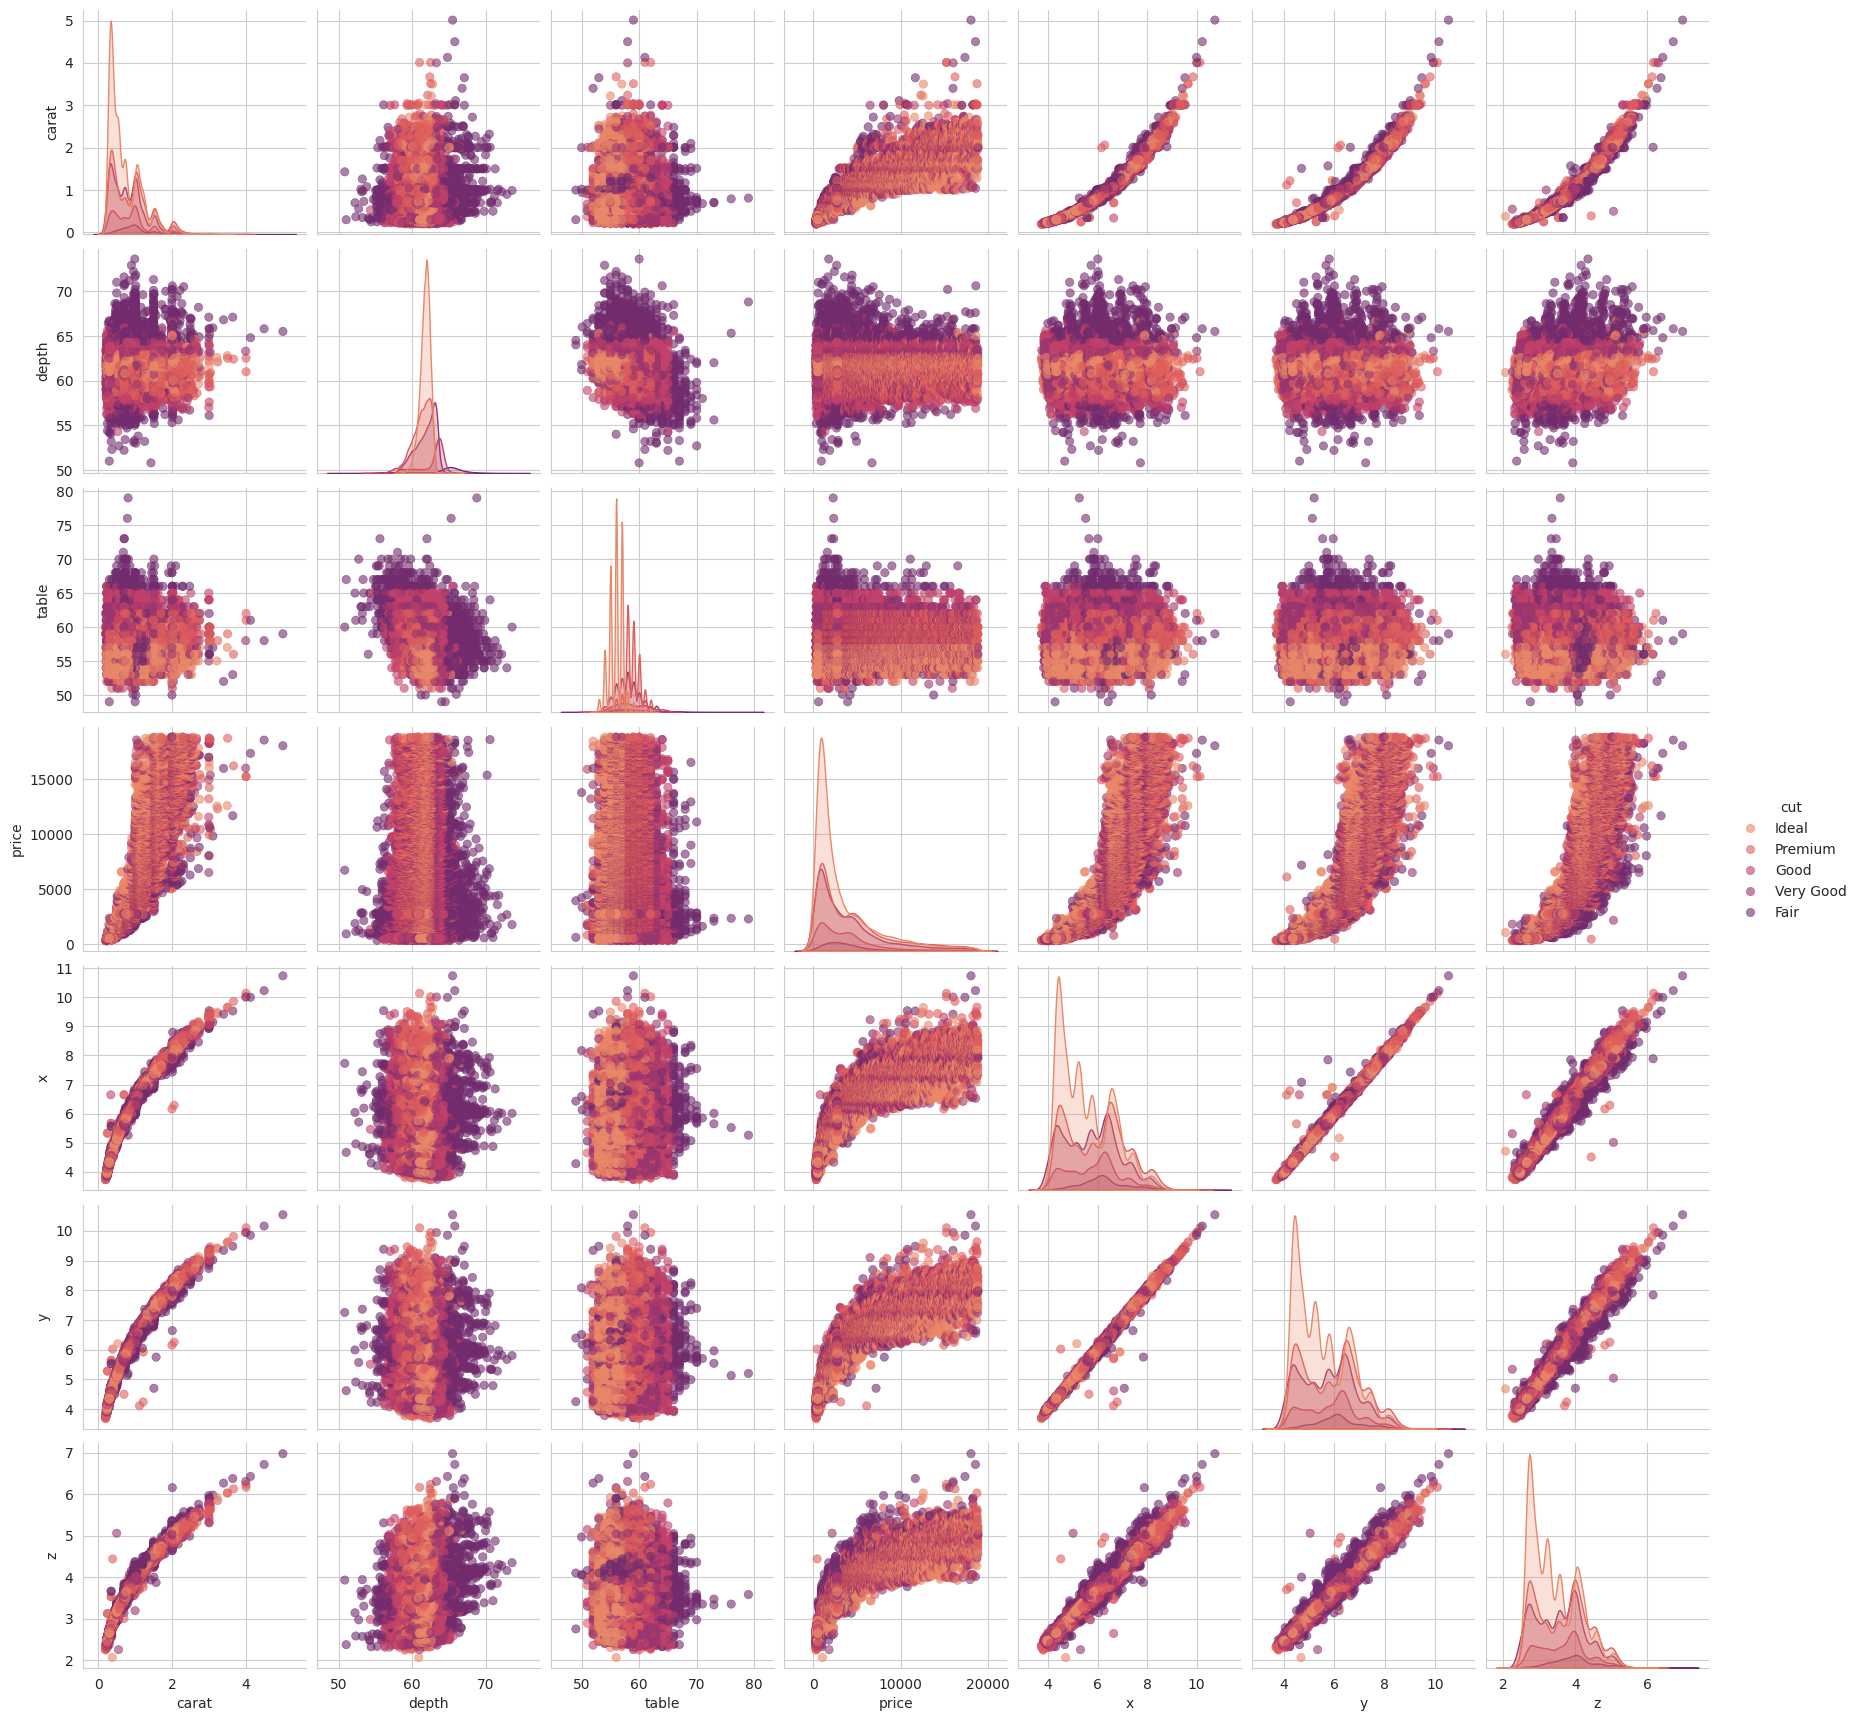

In [76]:
# Plota um pairplot novo para a visualização do dataset pós-remoção de outliers:
sns.pairplot(n_df, diag_kind = 'kde',
             hue = 'cut', palette = 'flare',
             plot_kws = dict(edgecolor = None, alpha = 0.6))

plt.show()

É perceptível como a visualização ficou melhor depois da remoção dos outliers. Isso também vai beneficiar e muito o nosso modelo no futuro. Por hora, a limpeza e o tratamento dos dados está completa. Partamos, então, para a próxima etapa:

----
### Transformação de dados:
#### Codificação de variáveis:
A segunda etapa é a transformação dos dados. Isso significa que vamo transformar dados não-quantitativos em dados quantitativos numéricos que possam ser lidos e interpretados por um modelo de maneira eficiente.

Primeiro, é importante detectar quais tipos de variáveis não são quantitativas. Podemos fazer isso de duas formas: buscando por variáveis categóricas filtrando apenas por variáveis que retornam "objetos" em vez de valores inteiros ou flutuantes ou procurando diretamente no dicionário criado por variáveis consideradas "qualitativas".

In [122]:
# Só um dos métodos é necessário; mas, para fins de prática, vamos usar os dois:
# Lê um dicionário previamente criado:
df_dict = pd.DataFrame(pd.read_csv('../data/external/diamond_dictionary.csv').to_dict())

# Filtrando apenas as variáveis categóricas em um dicionário:
cat_columns = df_dict[df_dict['tipo'] == 'qualitativa']

# Retorna uma tabela com todas as variáveis do tipo qualitativa no dicionário
cat_columns

,variável,descrição,tipo,subtipo
2,cut,"qualidade do corte (fair, good, very good, pre...",qualitativa,ordinal
3,color,"cor do diamante, de D (melhor) a J (pior)",qualitativa,ordinal
4,clarity,o quão claro (translúcido) é o diamante (I1 (p...,qualitativa,ordinal


In [124]:
# Alternativamente: busca por variáveis com dtype object e filtra por elas:
cat_vars = (n_df.dtypes == 'object')
obj_columns = list(cat_vars[cat_vars].index)

# Retorna apenas quais variáveis são do dtype object
obj_columns

['cut', 'color', 'clarity']

Independente do método usado, os dois resultados (obj_columns e cat_columns) servem o nosso propósito: filtrar, exatamente, quais variáveis são categoricas, a fim de aplicar uma solução que transforme-as em números que podem ser melhor interpretados pelo modelo de predição a ser treinado.

In [126]:
# Primeiro, vamos importar as bibliotecas usadas para o encoding das variáveis:
from sklearn.preprocessing import LabelEncoder

In [127]:
# Façamos mais um backup antes de mexer com o dataset já modificado:
model_df = n_df.copy()

model_df.shape

(53905, 10)

In [134]:
# Agora, transformamos os valores originalmente qualitativos das variáveis filtradas acima em valores quantificáveis:
label_encoder = LabelEncoder()
for col in obj_columns:
    model_df[col] = label_encoder.fit_transform(model_df[col])

# Exibe os novos valores quantificáveis
model_df[['cut', 'clarity', 'color']].head()

,cut,clarity,color
0,2,3,1
1,3,2,1
2,1,4,1
3,3,5,5
4,1,3,6


Agora que os valores estão quantificáveis, podemos começar o treinamento de um modelo de predição.

----
### Treinamento de modelo:
A última etapa é a criação de um modelo de predição de valor. O propósito final é permitir que o modelo identifique corretamente o preço de um diamante baseado nos dados fornecidos previamente pelo dataset.

Pra começar, podemos identificar quais são as variáveis com a correlação mais próxima do preço - que é o valor que queremos prever.

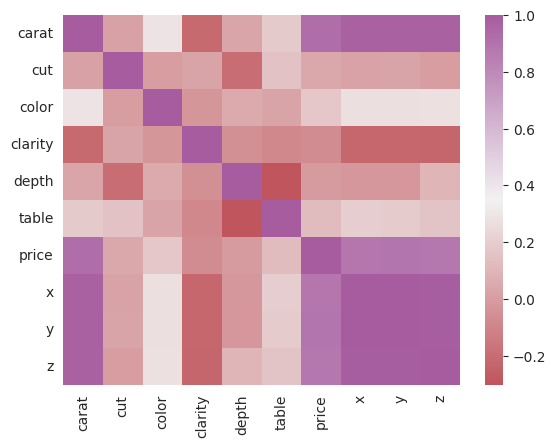

In [142]:
# Cria-se uma matriz de correlação
sns.heatmap(model_df.corr(), cmap = b_pal)

plt.show()

É possível perceber que o tamanho (x, y, z) e o peso (carat) dos diamantes possuem uma correlação muito maior (próxima de 1) com o valor.
Vamos usar, portanto, a variável que mais parecia estar relacionada com o valor durante nossa análise - o peso.

Mas, antes de tudo, é necessário dividir o nosso conjunto de dados em um conjunto sem a variável de preço e um conjunto **APENAS** coma variável de preço.

In [146]:
# Importa, do sklearn, o módulo que permite a divisão de conjuntos entre treino e teste
from sklearn.model_selection import train_test_split

In [155]:
# Divide o conjunto de dados em um conjunto de características e um outro apenas com a variável-alvo - no nosso caso, preço.
x = model_df.drop(['price'], axis = 1)
y = model_df['price']

# Divide o que nos temos entre um conjunto de treino (para ensinar o modelo) e um conjunto de teste (para verificar o modelo):
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, # --- particiona 1/5 do nosso conjunto para fins de teste
                                                    random_state = 7)

# Verifica a distribuição de valores entre os dois conjuntos:
print(f'Conjunto de treino:\n{x_train.shape}\n{y_train.shape}\nConjunto de testes:\n{x_test.shape}\n{y_test.shape}')

Conjunto de treino:
(43124, 9)
(43124,)
Conjunto de testes:
(10781, 9)
(10781,)


O próximo passo é criar pipelines que usam scalers padrão, um para cada modelo de regressão. Vamos trabalhar com quatro: Linear Regression, Random Forest, K-Neighbor e XGB.

In [162]:
# Importa do sklearn o que vamos usar:
# Importa o módulo de Pipelines
from sklearn.pipeline import Pipeline

# Importa nosso scaler
from sklearn.preprocessing import StandardScaler

# Importa os métodos de treino
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [166]:
# Cria uma pipeline com o SC para Linear Regression
pipe_lr = Pipeline([('scaler_1', StandardScaler()), ('lr_classifier', LinearRegression())])

# Cria uma pipeline com o SC para Random Forest
pipe_rf = Pipeline([('scaler_2', StandardScaler()), ('rf_classifier', RandomForestRegressor())])

# Cria uma pipeline com o SC para K-Neighbors
pipe_kn = Pipeline([('scaler_3', StandardScaler()), ('kn_classifier', KNeighborsRegressor())])

# Cria uma pipeline com o SC para Decision Tree
pipe_dt = Pipeline([('scaler_4', StandardScaler()), ('dt_classifier', DecisionTreeRegressor())])

# Dá fit nas pipelines:
# pipe_lr.fit(x_train, y_train)
# pipe_rf.fit(x_train, y_train)
# pipe_kn.fit(x_train, y_train)
# pipe_dt.fit(x_train, y_train)

In [173]:
# Cria uma estrutura de lista para as pipelines:
pipelines = [pipe_lr, pipe_rf, pipe_kn, pipe_dt]

# Dá fit nas pipelines:
for pipe in pipelines:
    pipe.fit(x_train, y_train)

Agora, faz-se necessário avaliar qual dos modelos melhor se encaixa em um cenário de predição. Para isso, podemos usar algumas métricas com a biblioteca sklearn.
Para os propósitos desta atividade, serão feitas três avaliações: R² (Coeficiente de Determinação), RMSE (Erro Quadrático Médio) e MAE (Erro Absoluto Médio).

In [168]:
# Importa três métricas para teste de precisão:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [177]:
# Cria um dicionário de identificação para as pipelines:
pipes = {
    'Linear Regression': pipe_lr,
    'Random Forest': pipe_rf,
    'K-Neighbors': pipe_kn,
    'Decision Tree': pipe_dt,
}

# Cria um dicionário para inserir os dados das métricas usadas:
metrics = {}

# Cria um loop que realiza os testes e joga no dicionário
for model_name, pipeline in pipes.items():
    y_pred = pipeline.predict(x_test) # - Previsão
    metrics[model_name] = {
    'R²': r2_score(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'MAE': mean_absolute_error(y_test, y_pred),
    }

# Exibe os resultados:
for model, scores in metrics.items():
    print(f'\n{model}:')
    for metric, value in scores.items():
        print(f'{metric}: {value:.2f}')


Linear Regression:
R²: 0.89
RMSE: 1342.33
MAE: 854.69

Random Forest:
R²: 0.98
RMSE: 544.27
MAE: 271.61

K-Neighbors:
R²: 0.96
RMSE: 804.09
MAE: 411.37

Decision Tree:
R²: 0.97
RMSE: 743.66
MAE: 361.48


Os scores do Random Forest são absolutamente superiores; seu R² permite uma explicabilidade mais precisa que os demais e seus Erro Quadrático Médio e Erro Absoluto Médio são os menores. O modelo de predição que utiliza a pipeline de RF seria, portanto, o ideal a se usar.